In [1]:
import numpy as np
import pandas  as pd
import networkx as nx
import random
import gensim
from gensim.models import Word2Vec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib.pyplot as plt

method = 'JUST'
database = 'dblp'

In [369]:
# Load data
def get_moive_data():
    label = pd.read_csv('Datasets/movie/movie_labels.txt',sep ='\t',header = None)
    del label[6]
    label['id'] = label[0].apply(lambda x:'m'+str(x))
    del label[0]
    label = label.set_index('id')
    l = []
    for i in label.index:
        l.append(label.loc[i].tolist())
    label['label'] = l
    label = label.reset_index()
    data = label[['id','label']]
    data = data[data['id'].apply(lambda x: x in  model.vocab.keys())]
    data['vector'] = data['id'].apply(lambda x:model[x])
    return data

def get_dblp_data():
    label = pd.read_csv('Datasets/DBLP/dblp_labels.txt',sep ='\t')
    label['label'] = 0
    for i,v in enumerate(label):
        if i!=0 and v!='label':
            label['label'] += i*label[v] 
    # label['label'] = label['database'] + 2*label['data mining']+3*label['machine learning']+ 4*label['information retrieval']
    label = label[label['author_id'].apply(lambda x: x in  model.vocab.keys())]
    label['vector'] = label['author_id'].apply(lambda x: model[x])
    data = label[['author_id','vector','label']].copy()
    data.loc[:,'id'] = data.loc[:,'author_id']
    del data['author_id']
    return data

def get_Foursquare_data():
    label = pd.read_csv('Datasets/Foursquare/Foursquare_labels.txt',sep =',',header = None)
    label['id'] = label[0]
    d = {}
    for i,v in enumerate(label[1].unique()):
        d[v] = i
    label['label'] = label[1].apply(lambda x:d[x])
    label = label[label['id'].apply(lambda x: x in  model.vocab.keys())]
    label['vector'] = label['id'].apply(lambda x:model[x])
    data = label[['id','label','vector']]
    return data

def get_data(d):
    if d == 'dblp':
        return get_dblp_data()
    elif d == 'movie':
        return get_moive_data()
    elif d == 'Foursquare':
        return get_Foursquare_data()

model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method+'/'+database+'.embeddings')
data = get_data(database)
data

,id,label,vector
0,p3,0,"[0.056821868, 3.204841, 2.5844395, 0.15786152,..."
1,p11,1,"[1.67837, -7.0052423, 2.0312335, 3.653613, 0.7..."
2,p26,1,"[-0.39827478, 2.3829324, 4.6395082, -2.872994,..."
3,p31,1,"[-0.4345197, 1.7211466, 3.985741, -0.66341764,..."
4,p33,1,"[-1.083629, -2.0506473, 2.7152627, -1.6304482,..."
...,...,...,...
1245,p10363356,0,"[-2.0953355, -0.75886, 1.3770804, -2.2033997, ..."
1246,p10386599,0,"[2.7860253, -0.85891676, -3.6662183, 0.9862518..."
1247,p10658749,5,"[-2.2419074, 0.3778921, -1.7616541, 0.9585489,..."
1248,p10708043,3,"[1.9968466, 6.4375825, -1.1361828, -1.046923, ..."


# 向量分布展示

In [370]:
# reduce dimensions to 2
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
result = tsne.fit_transform(data.vector.tolist())

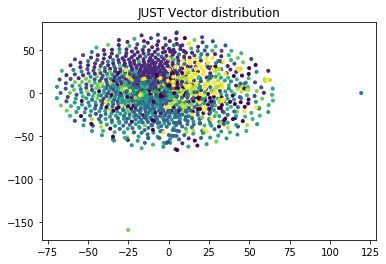

In [371]:
from sklearn.decomposition import PCA
def plot_nodes(data):
    data.loc[:,'x'] = result[:, 0] 
    data.loc[:,'y'] = result[:, 1]
    #plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.title(method+' Vector distribution')
    plt.scatter(data['x'],data['y'],c=data['label'],marker=".")
    plt.show()
plot_nodes(data.copy())

# 分类评估

In [382]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# 加载数据集
def load_data(data,a):
    # 将数据集拆分为训练集和测试集 
    X_train, X_test, y_train, y_test = train_test_split(
    data.vector.tolist(), data.label, test_size=a, random_state=0)
    return X_train, X_test, y_train, y_test

# 使用LogisticRegression评估
def test_LogisticRegression_multiomaial(data,a):
    
    X_train,X_test,y_train,y_test=load_data(data,a) # 产生用于回归问题的数据集
    y_train=y_train.tolist()
    y_test = y_test.tolist()
    # 选择模型
    
    if database == 'dblp' or database == 'Foursquare':
        cls = LogisticRegression(multi_class='multinomial',solver='lbfgs',  max_iter = 3000)
        # 把数据交给模型训练
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        f1_micro = f1_score(y_test,y_pred,average='micro')
        f1_macro = f1_score(y_test,y_pred,average='macro')
    if database == 'movie':
        #y_train=y_train.tolist()
        #y_test = y_test.tolist()
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        LR = LogisticRegression(solver='liblinear',multi_class='ovr',n_jobs=-1)
        model = OneVsRestClassifier(LR, n_jobs=-1)
        clf = model.fit(X_train, y_train)
        y_pred =  clf.predict(X_test)
        f1_micro = f1_score(y_test,y_pred,average='micro')
        f1_macro = f1_score(y_test,y_pred,average='macro')
    #print('F1:',f1_micro)
    return f1_micro,f1_macro


def get_F1(data):
    a_list = []
    Fmi_list = []
    Fma_list = []
    for a in range(1,10):
        a_list.append(a/10)
        f1_micro,f1_macro = test_LogisticRegression_multiomaial(data,1-a/10) # 调用 test_LinearRegression
        Fmi_list.append(f1_micro)
        Fma_list.append(f1_macro)
    result = pd.DataFrame({'rate':a_list,'F1_micro':Fmi_list,'F1_macro':Fma_list}).sort_values(by = 'rate')
    return result

In [383]:
# test
result  = get_F1(data)
result.to_csv('evaluation/'+method+'_'+ database+'.csv',index = 0)
result

,rate,F1_micro,F1_macro
0,0.1,0.465778,0.375630
1,0.2,0.484000,0.418513
2,0.3,0.484571,0.433322
3,0.4,0.474667,0.421396
4,0.5,0.497600,0.439739
5,0.6,0.504000,0.439352
6,0.7,0.531915,0.471634
7,0.8,0.492000,0.448425
8,0.9,0.528000,0.480538


# K-Means

In [386]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
def get_NMI():
    # Generate sample data
    np.random.seed(0)
    if database == 'dblp' or database =='Foursquare':
        n_clusters = len(data.label.unique())
    elif database == 'movie':
        n_clusters = len(data.label.apply(lambda x: tuple(x)).unique())
    X = data.vector.tolist()
    labels_true = data.label

    k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=-1)
    k_means.fit(X)
    y_pr = k_means.labels_
    NMI = normalized_mutual_info_score(data.label, y_pr,average_method='arithmetic')
    return NMI
get_NMI()

0.3076374975507758

In [387]:
# EVALUATION
methods = ['JUST','JUST_without_memory','Metapath2vec','DeepWalk']
database = 'Foursquare'
for method in methods:
    model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method+'/'+database+'.embeddings')
    data = get_data(database)
    result  = get_F1(data)
    result.to_csv('evaluation/'+method+'_'+ database+'.csv',index = 0)
    print(method,get_NMI())

JUST 0.28961910326873036
JUST_without_memory 0.22691858763297668
Metapath2vec 0.30203156023261307
DeepWalk 0.3076374975507758


In [ ]:
for method in methods:
    model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method+'/'+database+'.embeddings')
    data = get_data(database)
    result  = get_F1(data)
    result.to_csv('evaluation/'+method+'_'+ database+'.csv',index = 0)
    print(method,get_NMI())

In [507]:
# DBLP
# JUST 0.3238370241423881
# JUST_without_m 0.31306260401194075
# DeepWalk 0.3435931314794115
# Meta 0.4257625446361601

# Movie
# JUST 0.08532153739245388
# JUST_without_memory 0.0851112960452151
# Metapath2vec 0.07787051174564907
# DeepWalk 0.09046426924091013

# Foursquare
# JUST 0.2896358607652416
# JUST_without_memory 0.22691876124304308
# Metapath2vec 0.3020465631904861
# DeepWalk 0.30764600381893353

# 画图

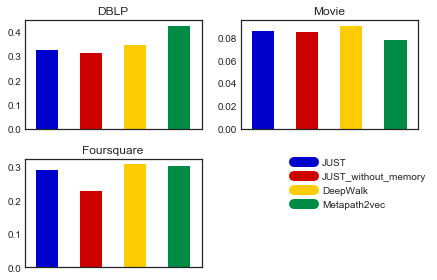

In [3]:
# draw bar
methods = ['JUST','JUST_without_memory','DeepWalk','Metapath2vec']
value1 = [0.3238370241423881,0.31306260401194075,0.3435931314794115,0.4257625446361601]
value2 = [0.08532153739245388,0.0851112960452151,0.09046426924091013,0.07787051174564907]
value3 = [0.2896358607652416,0.22691876124304308, 0.30764600381893353,0.3020465631904861]
df = pd.DataFrame({'DBLP':value1,'Movie':value2,'Foursquare':value3})
df.index = methods


fig = plt.figure()
plt.style.use('seaborn-white')
c=['#0000CD','#CD0000','#FFCC03','#008B45']
plt.subplot(221)
plt.title('DBLP')
df.DBLP.plot.bar(color=c)
plt.xticks([]) 
plt.subplot(222)
plt.title('Movie')
df.Movie.plot.bar(color=c)
plt.xticks([]) 

plt.subplot(223)
plt.title('Foursquare')
df.Foursquare.plot.bar(color=c)
plt.xticks([]) 
plt.tight_layout()

custom_lines = [Line2D([0], [0], color=c[0], lw=10),
                Line2D([0], [0], color=c[1], lw=10),
                Line2D([0], [0], color=c[2], lw=10),
                Line2D([0], [0], color=c[3], lw=10)]
plt.legend(custom_lines, methods,loc=[1.5,0.5])
#plt.savefig('evaluation/NMI.png',ppi=500)

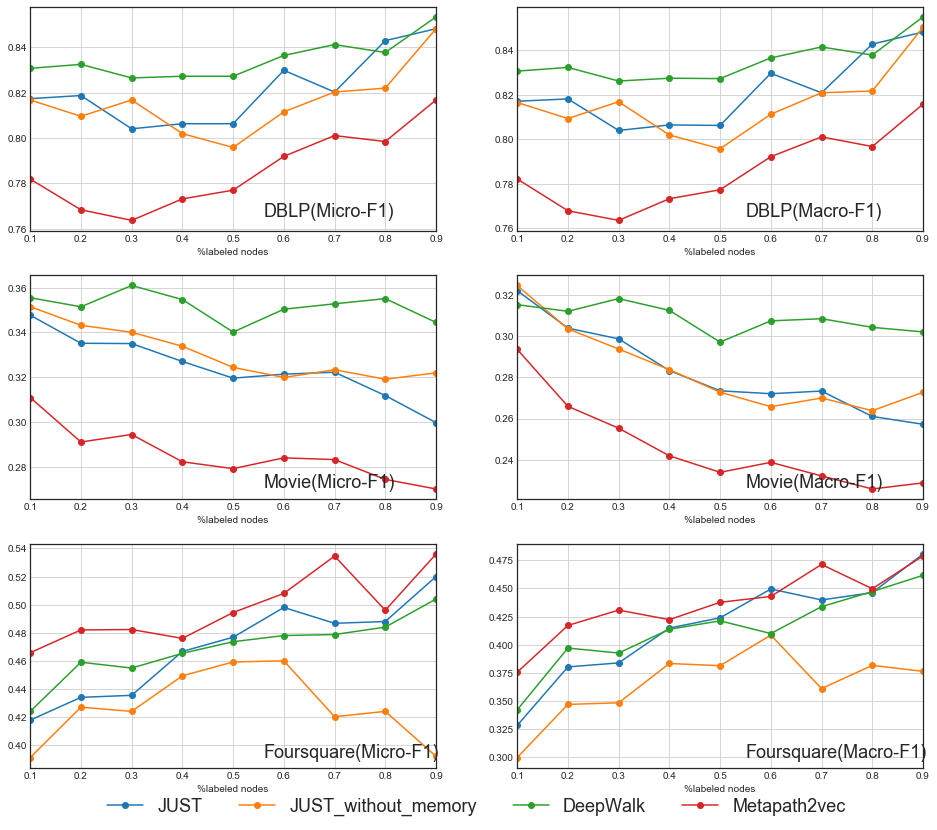

In [81]:
# draw line
fig,ax = plt.subplots(3,2,figsize=(16,14))
databases = ['dblp','movie','Foursquare']
for i,database in enumerate(databases):
    F1_micro = pd.DataFrame({'%labeled nodes':[i/10 for i in range(1,10)]})
    F1_macro = pd.DataFrame({'%labeled nodes':[i/10 for i in range(1,10)]})
    for method in methods:
        path = 'evaluation/'+method+'_'+database+'.csv'
        df = pd.read_csv(path)
        F1_micro[method] = df['F1_micro']
        F1_macro[method] = df['F1_macro']
    F1_micro = F1_micro.set_index('%labeled nodes')
    F1_macro = F1_macro.set_index('%labeled nodes')

    F1_micro.plot.line(ax = ax[i,0],grid = True,marker = 'o',legend = False)
    F1_macro.plot.line(ax = ax[i,1],grid = True,marker = 'o',legend = False)

    
custom_lines = [Line2D([0], [0], color=c[0], lw=10),
                Line2D([1], [0], color=c[1], lw=10),
                Line2D([0], [1], color=c[2], lw=10),
                Line2D([1], [1], color=c[3], lw=10)]
plt.text(-0.4,0.78,"DBLP(Micro-F1)",fontsize=18,)
plt.text(0.55,0.78,"DBLP(Macro-F1)",fontsize=18,)
plt.text(-0.4,0.54,"Movie(Micro-F1)",fontsize=18,)
plt.text(0.55,0.54,"Movie(Macro-F1)",fontsize=18,)
plt.text(-0.4,0.3,"Foursquare(Micro-F1)",fontsize=18,)
plt.text(0.55,0.3,"Foursquare(Macro-F1)",fontsize=18,)
plt.legend(loc='upper center', bbox_to_anchor=(-0.1,-0.1),ncol=4,fontsize = 18,borderaxespad=0.)
plt.savefig('evaluation/rate.png',ppi=900,bbox_inches='tight')